In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import random
import pickle

In [13]:
data_dir = "../../../user_data/rns_data"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [14]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning

pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [15]:
final_folder = 'save_acc'
path = os.listdir(final_folder)
num_round = 11
path

['BadgeSampling.npy',
 'BALDDropout.npy',
 'EntropySampling.npy',
 'EntropySamplingDropout.npy',
 'KCenterGreedyPCA.npy',
 'KMeansSampling.npy',
 'LeastConfidence.npy',
 'LeastConfidenceDropout.npy',
 'LossPredictionLoss.npy',
 'MarginSamplingDropout.npy',
 'MeanSTD.npy',
 'RandomSampling.npy',
 'RandomSampling_no_pretrain.npy',
 'save_acc.zip',
 'WAAL.npy']

In [16]:
path = np.array(path,dtype=object)[[0,1,2,3,4,5,6,7,8,9,10,11,12,14]]
path

array(['BadgeSampling.npy', 'BALDDropout.npy', 'EntropySampling.npy',
       'EntropySamplingDropout.npy', 'KCenterGreedyPCA.npy',
       'KMeansSampling.npy', 'LeastConfidence.npy',
       'LeastConfidenceDropout.npy', 'LossPredictionLoss.npy',
       'MarginSamplingDropout.npy', 'MeanSTD.npy', 'RandomSampling.npy',
       'RandomSampling_no_pretrain.npy', 'WAAL.npy'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


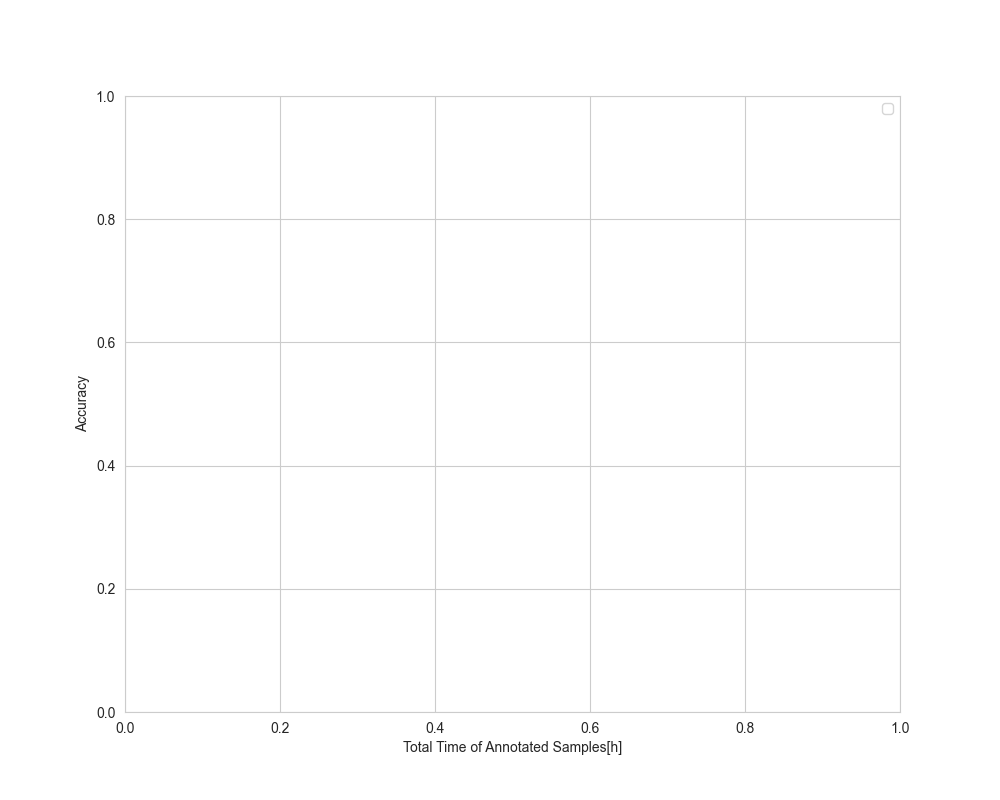

In [20]:

plt.figure(figsize=(10, 8))
active_learning_curve = {}

for i in range(len(path)):
    test_load = np.load(final_folder + '/' + path[i], allow_pickle=True).item()
    acc_round = []
    f1_round = []
    auc_round = []
    epsd_acc_round = []
    epsd_f1_round = []
    
    for key in test_load.keys():
        per_round = test_load[key]
        acc_ckpt = []
        f1_ckpt = []
        auc_ckpt = []
        epsd_acc_ckpt = []
        epsd_f1_ckpt = []
        for ckpt_result in per_round:
            acc_ckpt.append(ckpt_result[0])
            f1_ckpt.append(ckpt_result[1])
            auc_ckpt.append(ckpt_result[2])
            epsd_acc_ckpt.append(ckpt_result[3])
            epsd_f1_ckpt.append(ckpt_result[4])
        acc_round.append((np.mean(acc_ckpt),np.std(acc_ckpt)))
        f1_round.append((np.mean(f1_ckpt),np.std(f1_ckpt)))
        auc_round.append((np.mean(auc_ckpt),np.std(auc_ckpt)))
        epsd_acc_round.append((np.mean(epsd_acc_ckpt),np.std(epsd_acc_ckpt)))
        epsd_f1_round.append((np.mean(epsd_f1_ckpt),np.std(epsd_f1_ckpt)))
    
    
    strategy_name = path[i].split('.')[0]
    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
        selected_inds = pickle.load(f)
    
    add_size = []
    add_episode = []
    for key in list(selected_inds.keys()):
        add_size.append(len(selected_inds[key]))
        add_episode.append(np.sign(np.abs(np.diff(selected_inds[key])-1)).sum()+1)
    add_size_cumsum = np.cumsum(add_size)
    add_episode_cumsum = np.cumsum(add_episode)
    selected_len=add_size_cumsum/3600
    selected_episode=add_episode_cumsum
    
    accuracies, stds = zip(*acc_round)
    iterations = range(1, len(accuracies) + 1)
    
    # Create plot
    
    
    # plt.plot(selected_episode, accuracies, label=strategy_name, color=list(mcolors.TABLEAU_COLORS.keys())[i])
    # plt.fill_between(selected_episode, 
    #                  [a - s for a, s in zip(accuracies, stds)], 
    #                  [a + s for a, s in zip(accuracies, stds)], 
    #                  color=list(mcolors.TABLEAU_COLORS.keys())[i], alpha=0.1)
    
    df = pd.DataFrame()
    df['Number_of_Annotation'] = selected_episode
    df['Length_of_Annotation_hours'] = selected_len
    df['Accuracy'] = acc_round
    df['F1_score'] = f1_round
    df['AUCROC'] = auc_round
    df['ep_Acc'] = epsd_acc_round
    df['epsd_F1'] = epsd_f1_round
    
    active_learning_curve[strategy_name] = df
    
# plt.title('Active Learning Curve')
plt.xlabel('Total Time of Annotated Samples[h]')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
active_learning_curve.keys()

dict_keys(['BadgeSampling', 'BALDDropout', 'EntropySampling', 'EntropySamplingDropout', 'KCenterGreedyPCA', 'KMeansSampling', 'LeastConfidence', 'LeastConfidenceDropout', 'LossPredictionLoss', 'MarginSamplingDropout', 'MeanSTD', 'RandomSampling', 'RandomSampling_no_pretrain', 'WAAL'])

In [8]:
epsd_f1_round

[(0.5312423798543923, 0.1540865424420874),
 (0.8565298910810879, 0.0314564831248358),
 (0.8303639321870985, 0.03981244743967284),
 (0.8428643871548672, 0.0326929248531946),
 (0.8406225329653483, 0.031197149149950844),
 (0.8319592782425829, 0.044946785665402014),
 (0.7835369892392338, 0.06296908842073409),
 (0.8620492523274269, 0.031641186038103966),
 (0.8569823048238727, 0.02902030123473947),
 (0.8294430283923709, 0.044513401154860015),
 (0.8618048056953217, 0.041447102212357034)]

In [22]:
np.save('active_learning_curve_full.npy', active_learning_curve)

In [9]:
with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
        selected_inds = pickle.load(f)
        


In [10]:
selected_inds

{0: [5164,
  5165,
  5166,
  5167,
  5168,
  5169,
  5170,
  5171,
  5172,
  5173,
  5174,
  5175,
  5176,
  5177,
  5178,
  5179,
  5180,
  5181,
  5182,
  5183,
  5184,
  5185,
  5186,
  5187,
  5188,
  5189,
  5190,
  5191,
  5192,
  5193,
  5194,
  5195,
  5196,
  5197,
  5198,
  5199,
  5200,
  5201,
  5202,
  5203,
  5204,
  5205,
  5206,
  5207,
  5208,
  5209,
  5210,
  5211,
  5212,
  5213,
  5214,
  5215,
  5216,
  5217,
  5218,
  5219,
  5220,
  5221,
  5222,
  5223,
  5224,
  5225,
  5226,
  5227,
  5228,
  5229,
  5230,
  5231,
  5232,
  5233,
  5234,
  5235,
  5236,
  5237,
  5238,
  5239,
  5240,
  5241,
  5242,
  5243,
  5244,
  5245,
  5246,
  5247,
  5248,
  5249,
  5250,
  5251,
  5252,
  5253,
  7714,
  7715,
  7716,
  7717,
  7718,
  7719,
  7720,
  7721,
  7722,
  7723,
  7724,
  7725,
  7726,
  7727,
  7728,
  7729,
  7730,
  7731,
  7732,
  7733,
  7734,
  7735,
  7736,
  7737,
  7738,
  7739,
  7740,
  7741,
  7742,
  7743,
  7744,
  7745,
  7746,
  7747,
  774

In [109]:
new_selected_ind = {}
for i in range(7):
    new_selected_ind[i] = selected_inds[i]

In [111]:
new_selected_ind[7] = selected_inds[8]

In [112]:
new_selected_ind

{0: [5164,
  5165,
  5166,
  5167,
  5168,
  5169,
  5170,
  5171,
  5172,
  5173,
  5174,
  5175,
  5176,
  5177,
  5178,
  5179,
  5180,
  5181,
  5182,
  5183,
  5184,
  5185,
  5186,
  5187,
  5188,
  5189,
  5190,
  5191,
  5192,
  5193,
  5194,
  5195,
  5196,
  5197,
  5198,
  5199,
  5200,
  5201,
  5202,
  5203,
  5204,
  5205,
  5206,
  5207,
  5208,
  5209,
  5210,
  5211,
  5212,
  5213,
  5214,
  5215,
  5216,
  5217,
  5218,
  5219,
  5220,
  5221,
  5222,
  5223,
  5224,
  5225,
  5226,
  5227,
  5228,
  5229,
  5230,
  5231,
  5232,
  5233,
  5234,
  5235,
  5236,
  5237,
  5238,
  5239,
  5240,
  5241,
  5242,
  5243,
  5244,
  5245,
  5246,
  5247,
  5248,
  5249,
  5250,
  5251,
  5252,
  5253,
  7714,
  7715,
  7716,
  7717,
  7718,
  7719,
  7720,
  7721,
  7722,
  7723,
  7724,
  7725,
  7726,
  7727,
  7728,
  7729,
  7730,
  7731,
  7732,
  7733,
  7734,
  7735,
  7736,
  7737,
  7738,
  7739,
  7740,
  7741,
  7742,
  7743,
  7744,
  7745,
  7746,
  7747,
  774

In [113]:

with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
        pickle.dump(new_selected_ind, f)

In [46]:
selected_len

array([[0.21638889, 0.69611111, 1.17694444, 1.65388889, 2.14916667,
        2.64222222, 3.12166667, 3.60222222, 4.08305556, 4.56222222,
        5.04722222]])

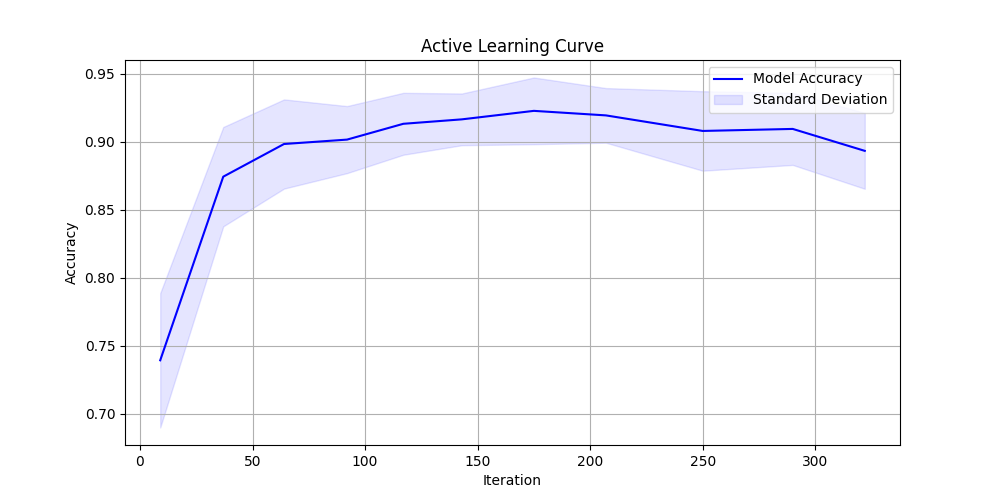

In [61]:

list(mcolors.TABLEAU_COLORS.keys())

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [55]:
np.array([a + s for a, s in zip(accuracies, stds)])-np.array([a - s for a, s in zip(accuracies, stds)])

array([0.04476048, 0.03426227, 0.03386572, 0.02976428, 0.02690344,
       0.02604951, 0.03295297, 0.02168595, 0.02407717, 0.02083414,
       0.02513201])

[0.7637563547649389,
 0.8846478201933475,
 0.8793538827159398,
 0.9176330820477508,
 0.9173140351607025,
 0.9250520213944734,
 0.9310536538442286,
 0.9397251833612646,
 0.9361977870611067,
 0.9458150734522323,
 0.9468523428502239]

In [50]:
stds

(0.02238023811562212,
 0.017131133900076027,
 0.01693286211443598,
 0.014882138938612665,
 0.013451721189096546,
 0.013024755164534519,
 0.016476482536242336,
 0.010842975132864256,
 0.012038587241639193,
 0.01041707040796953,
 0.012566003633582994)